In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table, coordinates
from astropy.io import fits
from astropy import units as u

from carpenter import pixels, conventions

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfparse import query
from ekfphot import photometry as ep

from agrias import utils, photometry

import reader

In [7]:
import sys
sys.path.append('../scripts/')
import do_directgalexphotometry

In [3]:
merian = table.Table(fits.getdata('../local_data/inputs/Merian_DR1_photoz_EAZY_v1.2.fits',1))
mcoords = coordinates.SkyCoord( merian['coord_ra_Merian'], merian['coord_dec_Merian'], unit='deg')
mcat = reader.merianselect(merian, av=0.3)

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [90]:
-2.5*np.log10(galex_direct.query('flux_fuv>0').dropna()['flux_fuv']/3631.).dropna().sort_values(ascending=False).iloc[400:410]

M3406203459966360746    21.254588
M3324887978022557647    21.254942
M3325442131882956283    21.257196
M3240986444730228527    21.257430
M3498514058187918062    21.258679
M3541456584322344631    21.259152
M3456086103495288997    21.260845
M3232880845010269303    21.262959
M3242798439892817621    21.263212
M3460224665262242637    21.270754
Name: flux_fuv, dtype: float64

In [99]:
bbmb, gi, emask = do_directgalexphotometry.singleton(mcat.loc['M3406203459966360746'], make_checkplot=True)

[SEDMap] Matching PSFs
    Copying to matched arrays ... 
        ... Done.
M3406203459966360746 maps to MISWZN09_24319_0198


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


M3406203459966360746 maps to MISWZN09_24319_0198


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


[GalexImaging] 10^(0.4*A_FUV) = 1.2535
[GalexImaging] 10^(0.4*A_NUV) = 1.2485


In [94]:
from ekfphot import photometry

In [95]:
-2.5*np.log10(photometry.convert_zeropoint(np.sum(gi.fuv_im[0].data[gi.emask]), gi._galex_zpt('NUV'), 8.9)/3631.)

22.61145546872565

In [96]:
-2.5*np.log10(photometry.convert_zeropoint(np.sum(gi.fuv_im[0].data), gi._galex_zpt('NUV'), 8.9)/3631.)

21.71234414491455

In [97]:
-2.5*np.log10(galex_direct.loc['M3037453648289353827', 'flux_fuv']/3631.)

19.77672405490174

(<matplotlib.contour.QuadContourSet at 0x17f45ab90>, <Axes: >)

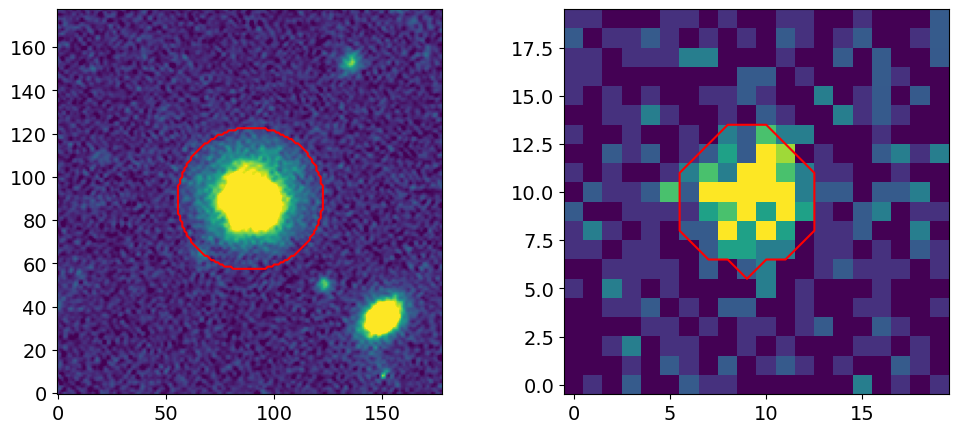

In [98]:
fig, axarr = plt.subplots(1,2,figsize=(12,5))
ek.imshow(bbmb.image['N708'], ax=axarr[0])
ek.contour(emask, colors='r', ax=axarr[0])

ek.imshow(gi.fuv_im[0].data, ax=axarr[1])
ek.contour(gi.emask, colors='r', ax=axarr[1])

In [4]:
merian_cg, galex_cg = reader.get_meriancrossgalex(mcat)

In [26]:
galex_direct = pd.read_csv('../local_data/output/galex_photometry.csv', index_col=0)

In [26]:
for col in galex_cg.columns:
    if 'fuv' in col:
        print(col)

fuv_exptime
fuv_mag
fuv_magerr
fuv_artifact


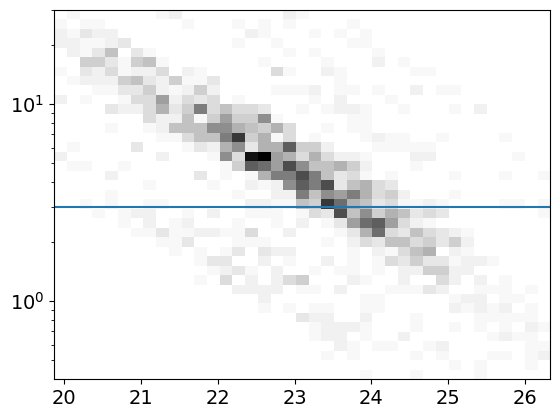

In [30]:
_=ek.hist2d (
    -2.5*np.log10(galex_direct['flux_fuv']/3631.),
    galex_direct['flux_fuv']/galex_direct['u_flux_fuv'],
    bins=40,
    yscale='log'
)
plt.axhline(3.)

In [ ]:
ek.hist2d(
    galex_cg.loc[mask, 'fuv_flux']/galex_cg.loc[mask, 'fuv_flux'],
    -2.5*np.log10(galex_direct.reindex(galex_cg.index).loc[mask, 'flux_fuv']/3631.),
    bins=40
)

Text(0, 0.5, '$m_{\\rm FUV}$, direct')

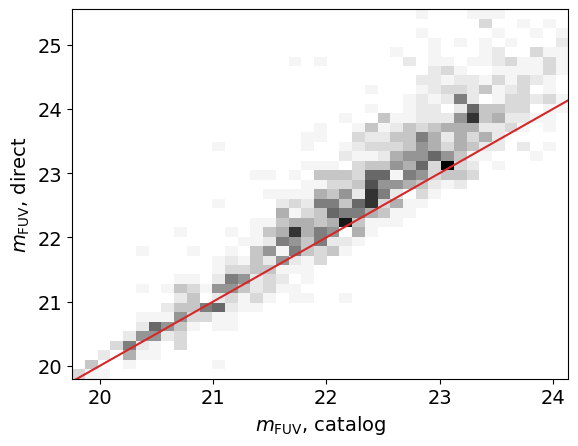

In [23]:
mask = galex_cg['fuv_mag']>0.
ek.hist2d(
    galex_cg.loc[mask, 'fuv_mag'],
    -2.5*np.log10(galex_direct.reindex(galex_cg.index).loc[mask, 'flux_fuv']/3631.),
    bins=40
)
xs = np.array([19.,25.])
plt.plot(xs,xs,color='tab:red')
plt.xlabel(r'$m_{\rm FUV}$, catalog')
plt.ylabel(r'$m_{\rm FUV}$, direct')

In [32]:
out = reader.compute_halphacorrections(mcat, use_dustengine=False)
emission_correction, ge_correction, dust_correction, aperture_correction = out

Computed line contamination in 0.0 seconds.
Computed Galactic extinction in 0.1 seconds.
Computed internal extinction in 0.1 seconds.
Computed aperture correction in 0.0 seconds.


In [34]:
packaged = {}
z_col = 'z_phot'

merian_cat = table.Table.from_pandas(mcat.reset_index())

haflux, u_haflux, halum, u_halum = photometry.mbestimate_halpha(
    merian_cat[utils.photcols['N708']],
    merian_cat[utils.photcols['r']],
    merian_cat[utils.photcols['i']],
    merian_cat[z_col],
    merian_cat[utils.u_photcols['N708']],
    merian_cat[utils.u_photcols['r']],
    merian_cat[utils.u_photcols['i']],    
    apercorr=aperture_correction[:].values,
    ge_correction=ge_correction[:,2],
    ex_correction=dust_correction[:,2],
    ns_correction=emission_correction[:],
    do_aperturecorrection=True,
    do_gecorrection=True,
    do_extinctioncorrection=True,
    do_linecorrection=True,
    specflux_unit=u.nJy
)